GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [19]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

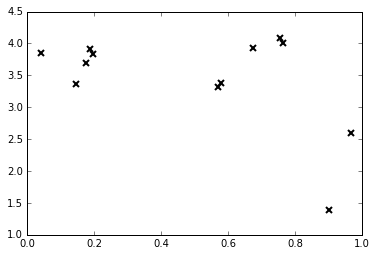

In [20]:
# build a very simple data set:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [21]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [22]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constriant
model.likelihood.variance,[ 0.01],None,+ve
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve
model.mean_function.A,[[ 1.]],None,(none)
model.mean_function.b,[ 0.],None,(none)


In [23]:
m.optimize()
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constriant
model.likelihood.variance,[ 0.00451501],None,+ve
model.kern.lengthscales,[ 0.06420982],None,+ve
model.kern.variance,[ 0.48215853],None,+ve
model.mean_function.A,[[-1.21416066]],None,(none)
model.mean_function.b,[ 3.96930877],None,(none)


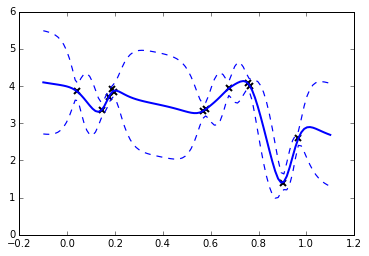

In [24]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [25]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constriant
model.likelihood.variance,[ 0.00451501],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.06420982],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 0.48215853],"Ga([ 1.],[ 1.])",+ve
model.mean_function.A,[[-1.21416066]],"N([ 0.],[ 10.])",(none)
model.mean_function.b,[ 3.96930877],"N([ 0.],[ 10.])",(none)


In [26]:

samples = m.sample(500, epsilon = 0.1, verbose=1)

compiling tensorflow function...
done
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  96.0 %


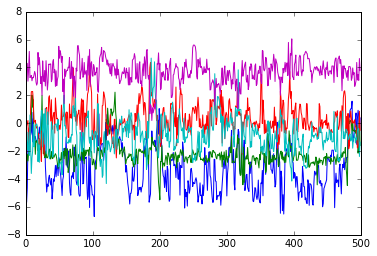

In [27]:
plt.figure()
plt.plot(samples)

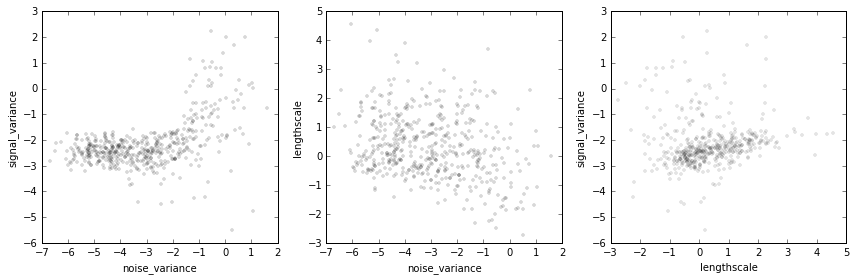

In [28]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

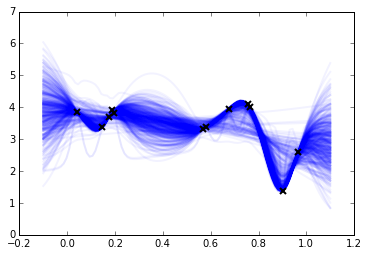

In [29]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)